## Создание системы быстрой диагностики владения английским языком.

В NICT JLE Corpus представлены текстовые образцы устной речи японцев, изучающих английский язык, а также носителей языка. Все испытуемые вступали в диалог с экспертом и либо отвечали на его вопросы, либо сочиняли истории, либо описывали одно из 6 изображений. Именно последний этап подлежит изучению.

По окончании испытания эксперт выставлял испытуемому оценку уровня владения английским языком. Эту оценку знаний необходимо предсказать по описанию изображений. 

Зачем это нужно?

1. Системы быстрой диагностики владения иностранным языком способны упростить прием на работу иностранных сотрудников, ускорить тестирование, а также проверку ответов и оценивание испытуемого. 

2. Исследуемый метод диагностики не предполагает возможности списывания и получения субъективной оценки, зависящей от эксперта.

3. При приеме иностранного сотрудника на работу работодатель может быть заинтересован в оценке владения языком в узкой области (например, английский язык в медицине). Подбор изображения, соответствующего данной области, может решить эту задачу.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import nltk
import seaborn as sns
import random
from nltk.corpus import stopwords
from mlxtend.plotting import heatmap
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, mean_absolute_error, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import re
import evaluate
smape_metric = evaluate.load("smape")
import sys
sys.path.insert(0, './sequence-labeler-master')
model_path = './files/cwi_seq.model'
temp_path = './files/temp_file.txt'
from files.complex_labeller import Complexity_labeller
nltk.download('punkt')
from collections import Counter
import torch
from optuna.trial import TrialState
from coral_pytorch.dataset import corn_label_from_logits
from coral_pytorch.losses import corn_loss
import time
from optuna import create_study
from optuna.exceptions import TrialPruned
from optuna.samplers import TPESampler
from early_stopping import EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Svetlana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from my_functions import dialog_processing, analyse_dialog, words_extractor, \
    pretty_dialog, avg_sentence_len, dialog_clear, nouns_of_dialog, get_unrich_of_speech, \
    set_seed, get_count_mistakes, get_meaning_coef, get_theme_nouns

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Svetlana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
seed = 1
set_seed(seed)

Random seed set as 1


Используем речь носителей языка как ориентир, выделив типичные слова для каждой тематики изображений

In [4]:
df_nat = pd.DataFrame({'name':'', 'theme':'', 'nouns':[]})
stop_words = set(stopwords.words('english'))

for file in os.listdir("./NICT_JLE/Native"):
    myfile = open(f"./NICT_JLE/Native/{file}", "rt")
    contents = myfile.read() 
    myfile.close()
    name = str(file)
    
    theme1 = contents[contents.find('<SST_task2>')+len('<SST_task2>'):contents.find('</SST_task2>')]
    contents = contents.replace(contents[contents.find('<SST_task2>'):contents.find('</SST_task2>')+len('</SST_task2>')], "")
    theme2 = contents[contents.find('<SST_task2>')+len('<SST_task2>'):contents.find('</SST_task2>')]

    border = contents.find('</task>') + len('</task>')
    dialog1, len1 = dialog_processing(contents)
    dialog2, len2 = dialog_processing(contents[border:])
    
    text1 = words_extractor(dialog1)
    text2 = words_extractor(dialog2)
    nouns1 = nouns_of_dialog(text1, stop_words)
    nouns2 = nouns_of_dialog(text2, stop_words)
    
    df_nat.loc[len(df_nat)] = name, theme1, nouns1
    df_nat.loc[len(df_nat)] = name, theme2, nouns2
    
    theme_nouns, themes = get_theme_nouns(df_nat)

df_nat.head()

,name,theme,nouns
0,N_file00001.txt,restaurant,"[looks, glass, restaurant, waiter, woman, tabl..."
1,N_file00001.txt,classroom,"[lot, girls, attention, classroom, students, t..."
2,N_file00002.txt,room,"[room, desk, computer, stereo, dormitory, hous..."
3,N_file00002.txt,neighborhood,"[street, couple, there's, man, neighborhood, h..."
4,N_file00003.txt,map,"[station, there's, river, school, bank, office..."


Из образцов устной речи выделим следующие признаки:
1) тема изображения
2) используемые в речи существительные
3) коэффициент смыслового соответствия речи изображению
4) число ошибок в речи
5) словарный запас 
6) количество пауз 
7) количество повторений
8) количество самопоправлений
9) количество слов родного языка
10) незаконченность предложений
11) количество слов в описании изображения
12) средняя длина предложения
13) оценка, полученная испытуемым

In [5]:
df = pd.DataFrame({'theme':'','nouns':[],'meaning_coef':[], 'count_mistakes':[], 'unrich':[], 'len_a':[],'repetitions':[], \
    'pauses_len':[], 'filled_pauses':[], 'self_correction':[], 'japans':[], 'is_unfinished':[], 'len':[], 'sentence_len':[], 'sst':[]})

for file in os.listdir("./NICT_JLE/LearnerOriginal"):
    myfile = open(f"./NICT_JLE/LearnerOriginal/{file}", "rt") 
    contents = myfile.read()        
    myfile.close()
    sst = int(contents[contents.find('<SST_level>')+len('<SST_level>'):contents.find('</SST_level>')])
    theme = contents[contents.find('<SST_task2>')+len('<SST_task2>'):contents.find('</SST_task2>')]
    
    dialog, len_a = dialog_processing(contents)
    repetitions, pauses_len, filled_pauses, self_correction, japans, is_unfinished = analyse_dialog(dialog)
    words = words_extractor(dialog)
    length = len(words)
    dialog = pretty_dialog(words)
    sentence_len, count_one_word_sentences = avg_sentence_len(dialog)
    
    nouns = nouns_of_dialog(words, stop_words)
    count_mistakes = get_count_mistakes(words, count_one_word_sentences)
    meaning_coef = get_meaning_coef(nouns, theme_nouns, themes, theme)
    unrich = get_unrich_of_speech(dialog)

    if float(str(file)[4:9]) % 100 == 0:
        print(file)

    df.loc[len(df)] = theme, nouns, meaning_coef, count_mistakes, unrich, len_a, repetitions, pauses_len, filled_pauses, \
    self_correction, japans, is_unfinished, length, sentence_len, sst
    
df.head(3)

file00100.txt
file00200.txt
file00300.txt
file00400.txt
file00500.txt
file00600.txt
file00700.txt
file00800.txt
file00900.txt
file01000.txt
file01100.txt
file01200.txt


,theme,nouns,meaning_coef,count_mistakes,unrich,len_a,repetitions,pauses_len,filled_pauses,self_correction,japans,is_unfinished,len,sentence_len,sst
0,neighborhood,"[road, car, houses, yes, day, town, guess, lot...",9,3,0.422222,83,10,6,13,3,1,1,518,10.777778,4
1,restaurant,"[kind, party, place, restaurant, couples, dish...",6,2,0.250000,79,7,16,15,2,0,0,228,4.714286,5
2,room,"[desk, cat, room, chair, computer, facsimile, ...",8,1,0.592593,625,7,18,19,3,0,0,377,7.444444,5


На основе используемых существительных определим сложность речи

In [6]:
def get_prob(model, word):
    Complexity_labeller.convert_format_string(model,word)
    prob = Complexity_labeller.get_prob_labels(model)
    return prob[0]
    
model = Complexity_labeller(model_path, temp_path)

all_nouns = [item for sublist in df['nouns'] for item in sublist]
unique = list(set(all_nouns))
compl = list(map(lambda word: get_prob(model, word), unique))
df['complexity']= [None]*len(df['nouns'])

for i in range(len(df['nouns'])):
    length = len(df['nouns'][i])
    df['complexity'][i] = [None]*length
    for j in range(length):
        df['complexity'][i][j] = compl[unique.index(df['nouns'][i][j])].astype(float)
    df['complexity'][i] = sum(df['complexity'][i])

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


c:\Users\Svetlana\Desktop\Projects\VKR\diploma\files\labeler.py:138: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  char_lstm_cell_fw = tf.nn.rnn_cell.LSTMCell(self.config["char_recurrent_size"],
c:\Users\Svetlana\Desktop\Projects\VKR\diploma\files\labeler.py:143: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  char_lstm_cell_bw = tf.nn.rnn_cell.LSTMCell(self.config["char_recurrent_size"],
From c:\Users\Svetlana\Desktop\Projects\VKR\diploma\files\labeler.py:149: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


From c:\Users\Svetlana\Desktop\Projects\VKR\.venv\lib\site-packages\tensorflow\python\ops\rnn.py:437: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


From c:\Users\Svetlana\Desktop\Projects\VKR\.venv\lib\site-packages\keras\layers\rnn\legacy_cells.py:1048: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
c:\Users\Svetlana\Desktop\Projects\VKR\diploma\files\labeler.py:162: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  char_output_tensor = tf.layers.dense(char_output_tensor, char_hidden_layer_size, activation=tf.tanh, kernel_initializer=self.initializer)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


c:\Users\Svetlana\Desktop\Projects\VKR\diploma\files\labeler.py:179: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  attention_output = tf.layers.dense(attention_evidence_tensor, self.config["word_embedding_size"], activation=tf.tanh, kernel_initializer=self.initializer)
c:\Users\Svetlana\Desktop\Projects\VKR\diploma\files\labeler.py:180: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  attention_output = tf.layers.dense(attention_output, self.config["word_embedding_size"], activation=tf.sigmoid, kernel_initializer=self.initializer)
From c:\Users\Svetlana\Desktop\Projects\VKR\.venv\lib\site-packages\tensorflow\python\util\dispatch.py:1176: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_p

In [7]:
df.insert(3, 'complexity', df.pop('complexity'))
df.head()

,theme,nouns,meaning_coef,complexity,count_mistakes,unrich,len_a,repetitions,pauses_len,filled_pauses,self_correction,japans,is_unfinished,len,sentence_len,sst
0,neighborhood,"[road, car, houses, yes, day, town, guess, lot...",9,2.464269,3,0.422222,83,10,6,13,3,1,1,518,10.777778,4
1,restaurant,"[kind, party, place, restaurant, couples, dish...",6,2.352676,2,0.250000,79,7,16,15,2,0,0,228,4.714286,5
2,room,"[desk, cat, room, chair, computer, facsimile, ...",8,4.63618,1,0.592593,625,7,18,19,3,0,0,377,7.444444,5
3,electric shop,"[shopmaster, watch, please, christmas, gift, p...",3,1.434073,4,0.464286,145,5,10,19,4,0,0,315,4.636364,4
4,neighborhood,"[town, children, volleyball, something, cat, c...",5,1.406514,0,0.275862,140,5,12,37,5,0,0,332,5.200000,4


### Аномалии

In [8]:
ddf = df.copy()
cols = ddf.iloc[:, 2:-1].columns
for column in cols:
    for i in range(0, 12):  
        desc = ddf.loc[ddf['sst']==i, column].describe()
        if desc[0] != 0:
            border = desc[-2]+1.5*(desc[-2]-desc[-4])
            ddf = ddf.drop(ddf[(ddf['sst']==i) & (ddf[column] > border)].index)

### SMOTE

Сбалансируем классы и изучим корреляции признаков

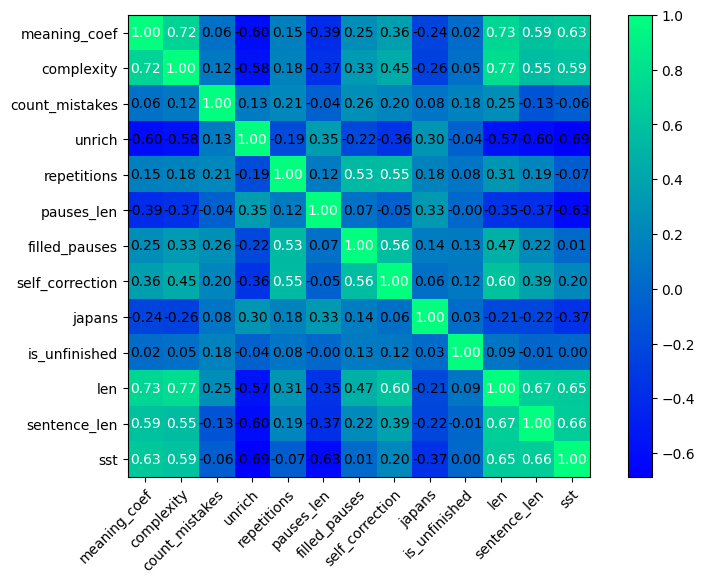

In [9]:
ddf = df.copy()
ddf.complexity = ddf.complexity.astype(float)
smote = SMOTE(sampling_strategy='not majority', k_neighbors=2)
ddf = ddf.drop(['len_a'], axis=1)
X = ddf.iloc[:, 2:-1]
y = ddf.iloc[:, -1]
X_sm, y_sm = smote.fit_resample(X, y)
cmap = np.corrcoef(np.hstack((X_sm, np.expand_dims(y_sm, axis=1) )).T )
hm = heatmap(cmap, row_names=ddf.columns[2:], column_names=ddf.columns[2:], figsize=(10, 6), cmap=plt.cm.winter)

#### Baseline

Чтобы решить задачу порядковой регрессии, недостаточно обучить классификатор, ведь он не воспринимает отношения между классами.
Сперва используем алгоритм линейной регрессии и округлим полученные значения до целых, чтобы получить опорные значения метрик.

mse:  1.5421246055189943
mae:  1.0037511888028365
mape:  0.280330888440955
0.30184331797235026
0.2963759457439606


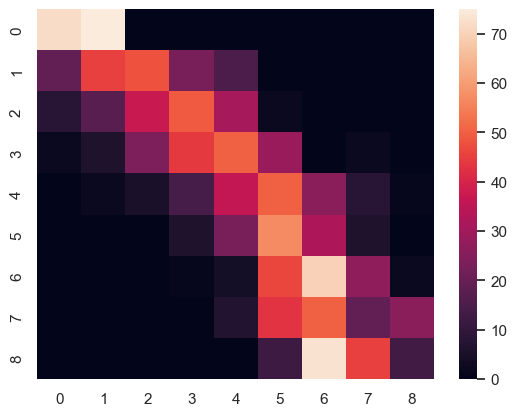

In [39]:
sc = StandardScaler()
y = ddf['sst'].values.astype('float')
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.3, random_state=seed)

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#regression
slr = LinearRegression()
slr.fit(X_train_std, y_train)
y_pred = slr.predict(X_test_std)
print('mse: ', mean_squared_error(y_test, y_pred))
print('mae: ', mean_absolute_error(y_test, y_pred))
print('mape: ', mape(y_test, y_pred))

#classification
y_pred =y_pred.round(0).astype(int)
y_pred = np.clip(y_pred, 1, 9) 
sns.heatmap(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

Используем более сложный алгоритм и заметим улучшение показателей

mse:  0.7361763543944438
mae:  0.6351189920081706
mape:  0.14405592224848837
accuracy:  0.5184331797235023
f1 score:  0.5210308084583745


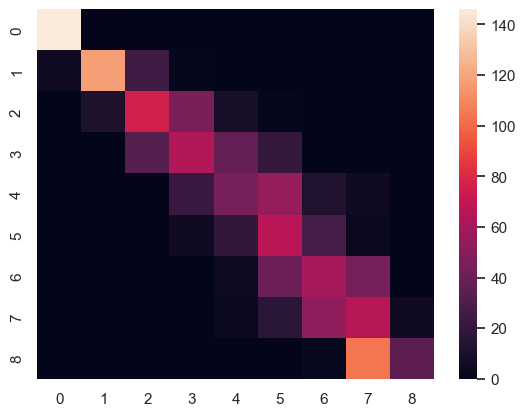

In [40]:
# Gradient Boosting Regressor
regr = GradientBoostingRegressor(random_state=seed)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
regr.fit(X_train_std, y_train)
y_pred = regr.predict(X_test_std)

# regression
print('mse: ', mean_squared_error(y_test, y_pred))
print('mae: ', mean_absolute_error(y_test, y_pred))
print('mape: ', mape(y_test, y_pred))

# classification
y_pred =y_pred.round(0).astype(int)
y_pred = np.clip(y_pred, 1, 9) 
sns.heatmap(confusion_matrix(y_test, y_pred))
print('accuracy: ', accuracy_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred, average='weighted'))

### CORN

CORN - Conditional Ordinal Regression for Neural Networks (https://arxiv.org/abs/2111.08851)

In [41]:
needed_cols = list(ddf.columns)[2:]
data_df = pd.DataFrame(np.hstack((X_sm, np.expand_dims(y_sm, axis=1) )), columns = needed_cols)
data_df["sst"] = data_df["sst"]-1 

data_labels = data_df["sst"].astype(int)
data_features = data_df.loc[:, needed_cols[:-1]]

print('Number of features:', data_features.shape[1])
print('Labels:', np.unique(data_labels.values))
print('Label distribution:', np.bincount(data_labels))

X_train, X_test, y_train, y_test = train_test_split(
    data_features.values[50:], data_labels.values[50:], test_size=0.2, random_state=seed, stratify=data_labels.values[50:])
    
eval_data = data_features.values[:50]
eval_target = data_labels.values[:50]
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Number of features: 12
Labels: [0 1 2 3 4 5 6 7 8]
Label distribution: [482 482 482 482 482 482 482 482 482]


### Before tuning

In [42]:
batch_size = 32
num_classes = np.bincount(data_labels).shape[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on', device)

Training on cpu


In [43]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, feature_array, label_array, dtype=np.float32):
        self.features = feature_array.astype(np.float32)
        self.labels = label_array

    def __getitem__(self, index):
        inputs = self.features[index]
        label = self.labels[index]
        return inputs, label

    def __len__(self):
        return self.labels.shape[0]

train_dataset = MyDataset(X_train_std, y_train)
test_dataset = MyDataset(X_test_std, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

for inputs, labels in train_loader:  
    print('Input batch dimensions:', inputs.shape)
    print('Input label dimensions:', labels.shape)
    break

class MLP(torch.nn.Module):
    def __init__(self, in_features, num_classes, num_hidden_1=500, num_hidden_2=300, dropout1=0.2, dropout2=0.2):
        super().__init__()
        self.my_network = torch.nn.Sequential(
            torch.nn.Linear(in_features, num_hidden_1, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(dropout1),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(dropout2),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.Linear(num_hidden_2, (num_classes-1))
        )

    def forward(self, x):
        logits = self.my_network(x)
        return logits

Input batch dimensions: torch.Size([32, 12])
Input label dimensions: torch.Size([32])


In [44]:
model = MLP(in_features=data_features.shape[1], num_classes=num_classes, num_hidden_1=300)
model.to(device)
learning_rate = 0.001
num_epochs = 30
l2_lambda = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, class_labels) in enumerate(train_loader):
        
        class_labels = class_labels.to(device)
        features = features.to(device)
        logits = model(features)
        loss = corn_loss(logits, class_labels, num_classes) + l2_lambda*sum(p.pow(2.0).sum()
                  for p in model.parameters())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 200:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), loss))

Epoch: 001/030 | Batch 000/108 | Cost: 1.5617
Epoch: 002/030 | Batch 000/108 | Cost: 0.9169
Epoch: 003/030 | Batch 000/108 | Cost: 0.7392
Epoch: 004/030 | Batch 000/108 | Cost: 0.6140
Epoch: 005/030 | Batch 000/108 | Cost: 0.5502
Epoch: 006/030 | Batch 000/108 | Cost: 0.4901
Epoch: 007/030 | Batch 000/108 | Cost: 0.4040
Epoch: 008/030 | Batch 000/108 | Cost: 0.4282
Epoch: 009/030 | Batch 000/108 | Cost: 0.3668
Epoch: 010/030 | Batch 000/108 | Cost: 0.3723
Epoch: 011/030 | Batch 000/108 | Cost: 0.3175
Epoch: 012/030 | Batch 000/108 | Cost: 0.3020
Epoch: 013/030 | Batch 000/108 | Cost: 0.3216
Epoch: 014/030 | Batch 000/108 | Cost: 0.2561
Epoch: 015/030 | Batch 000/108 | Cost: 0.2599
Epoch: 016/030 | Batch 000/108 | Cost: 0.3050
Epoch: 017/030 | Batch 000/108 | Cost: 0.2655
Epoch: 018/030 | Batch 000/108 | Cost: 0.2719
Epoch: 019/030 | Batch 000/108 | Cost: 0.2443
Epoch: 020/030 | Batch 000/108 | Cost: 0.2893
Epoch: 021/030 | Batch 000/108 | Cost: 0.2657
Epoch: 022/030 | Batch 000/108 | C

In [45]:
def compute_metrics(model, data_loader, device):
    with torch.no_grad():
        mae, mse, smape, acc, num_examples = 0., 0., 0., 0., 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            predicted_labels = corn_label_from_logits(logits).float()

            num_examples += targets.size(0)
            mae += torch.sum(torch.abs(predicted_labels - targets))
            smape += len(targets) * smape_metric.compute(predictions=predicted_labels, references=targets)['smape']
            mse += torch.sum((predicted_labels - targets)**2)

        mae = mae / num_examples
        smape = 100 * smape / num_examples
        mse = mse / num_examples
        return mae, smape, mse
        
train_mae, train_smape, train_mse = compute_metrics(model, train_loader, device)
test_mae, test_smape, test_mse = compute_metrics(model, test_loader, device)
print(f'MAE, Mean absolute error (train/test): {train_mae:.2f} | {test_mae:.2f}')
print(f'SMAPE, Mean absolute percent error (train/test): {train_smape:.2f}% | {test_smape:.2f}%')
print(f'MSE, Mean squared error (train/test): {train_mse:.2f} | {test_mse:.2f}')

MAE, Mean absolute error (train/test): 0.41 | 0.49
SMAPE, Mean absolute percent error (train/test): 10.71% | 12.65%
MSE, Mean squared error (train/test): 0.67 | 0.78


### Tuning

Используем optuna - фреймворк для оптимизации гиперпараметров.
Будем варьировать число нейронов в слоях и скорость обучения

In [57]:
class MLP_eval(torch.nn.Module):
    def __init__(self, in_features, num_classes, trial, num_hidden_1=500, num_hidden_2=300, dropout_1=0.2, dropout_2=0.1):
        super().__init__()
        layers = []
        out_features1 = trial.suggest_int("n_units_l{}".format(1), 300, 500)
        out_features2 = trial.suggest_int("n_units_l{}".format(2), 300, 500)
        out_features = [out_features1, out_features2]
        for layer in range(2):
            layers.append(torch.nn.Linear(in_features, out_features[layer], bias=True))
            layers.append(torch.nn.LeakyReLU())
            layers.append(torch.nn.Dropout(dropout_1))
            layers.append(torch.nn.BatchNorm1d(out_features[layer]))
            in_features = out_features[layer]
        layers.append(torch.nn.Linear(in_features, num_classes-1))
        self.my_network = torch.nn.Sequential(*layers)

    def forward(self, x):
        logits = self.my_network(x)
        return logits

Будем отслеживать SMAPE - альтернативу легко интерпретируемой MAPE. 

Значения этих метрик, меньшие 25%, практически совпадают

https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc

![Picture title](image-20230424-174000.png)

In [58]:
def objective(trial):
    model =  MLP_eval(in_features=data_features.shape[1], num_classes=num_classes, trial=trial).to(device)
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    l2_lambda = 0.001
    num_epochs = 30

    for epoch in range(num_epochs):
        
        model = model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            targets = targets.to(device)
            features = features.to(device)
            logits = model(features)
            loss = corn_loss(logits, targets, num_classes) + l2_lambda*sum(p.pow(2.0).sum()
                  for p in model.parameters())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            smape, num_examples = 0., 0.
            for i, (features, targets) in enumerate(test_loader):
                features = features.to(device)
                targets = targets.float().to(device)
                logits = model(features)
                predicted_labels = corn_label_from_logits(logits).float()
                num_examples += targets.size(0)
                smape += len(targets) * smape_metric.compute(predictions=predicted_labels, references=targets)['smape']

        smape = 100 * smape / num_examples
        trial.report(smape, epoch)
        if trial.should_prune():
            raise TrialPruned()
    return smape

In [59]:
study = create_study(direction="minimize", sampler=TPESampler())
study.optimize(objective, n_trials=30, timeout=12000)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-24 16:37:05,951] A new study created in memory with name: no-name-42ee6b41-ce03-4bf5-95be-cdae2218aaa7
[I 2023-04-24 16:37:45,338] Trial 0 finished with value: 9.196485979702762 and parameters: {'n_units_l1': 401, 'n_units_l2': 453, 'lr': 0.00027779289002389054}. Best is trial 0 with value: 9.196485979702762.
[I 2023-04-24 16:38:27,903] Trial 1 finished with value: 8.675904515065355 and parameters: {'n_units_l1': 470, 'n_units_l2': 481, 'lr': 0.0003105115600242389}. Best is trial 1 with value: 8.675904515065355.
[I 2023-04-24 16:39:08,163] Trial 2 finished with value: 9.689943571062454 and parameters: {'n_units_l1': 420, 'n_units_l2': 406, 'lr': 0.00012314221376017207}. Best is trial 1 with value: 8.675904515065355.
[I 2023-04-24 16:39:50,878] Trial 3 finished with value: 8.74311003681633 and parameters: {'n_units_l1': 451, 'n_units_l2': 499, 'lr': 0.0002756605783531753}. Best is trial 1 with value: 8.675904515065355.
[I 2023-04-24 16:40:33,209] Trial 4 finished with value: 

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  24
  Number of complete trials:  6
Best trial:
  Value:  8.675904515065355
  Params: 
    n_units_l1: 470
    n_units_l2: 481
    lr: 0.0003105115600242389


Зафиксируем найденные гиперпараметры

In [64]:
with open("hyperparams.txt", "a") as f:
    f.write("\n\nBest trial:")
    trial = study.best_trial
    f.write(f"\nValue: {trial.value}")
    f.write(" \nParams:")
    for key, value in trial.params.items():
        f.write("\n    {}: {}".format(key, value))

Применим early stopping

In [60]:
model_best = MLP(in_features=data_features.shape[1], num_classes=num_classes, num_hidden_1=470, num_hidden_2=481, \
    dropout1=0.2, dropout2=0.1)
model_best.to(device)
learning_rate = 0.0003105115600242389
optimizer = torch.optim.Adam(model_best.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

cost_train = []
cost_val = []
smape_train = []
smape_val = []
l2_lambda = 0.001
num_epochs = 150
early_stopping = EarlyStopping(patience=10, verbose=True)
count_of_epochs = 0

for epoch in range(num_epochs):
    
    num_examples = 0
    pre_train = 0
    smape = 0
    model_best = model_best.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        targets = targets.to(device)
        features = features.to(device)
        logits = model_best(features)
        predicted_labels = corn_label_from_logits(logits).float()
        num_examples += targets.size(0)

        loss = corn_loss(logits, targets, num_classes) + l2_lambda*sum(p.pow(2.0).sum()
                  for p in model_best.parameters())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pre_train += loss
        smape += len(targets) * smape_metric.compute(predictions=predicted_labels, references=targets)['smape']

        if not batch_idx % 200:
            print ('Epoch: %03d/%03d | Cost (train): %.4f ' %(epoch+1, num_epochs, loss))

    cost_train.append(pre_train/len(targets)) 
    smape_train.append(100*smape / num_examples)

    model_best.eval()
    with torch.no_grad():
        pre_val = 0
        smape = 0
        num_examples = 0
        for batch_idx, (features, targets) in enumerate(test_loader):  

            features = features.to(device)
            targets = targets.to(device)
            logits = model_best(features)
            num_examples += targets.size(0)
            predicted_labels = corn_label_from_logits(logits).float()
            val_loss = corn_loss(logits, targets, num_classes) + l2_lambda*sum(p.pow(2.0).sum()
                  for p in model_best.parameters())
            pre_val+= val_loss
            num_examples += targets.size(0)
            smape += len(targets) * smape_metric.compute(predictions=predicted_labels, references=targets)['smape']

        cost_val.append(pre_val/len(targets))
        smape_val.append(100*smape / num_examples)
        
    early_stopping(cost_val[-1], model_best)
       
    if early_stopping.early_stop:
        print("Early stopping")
        break

count_of_epochs = epoch         
model_best.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 001/150 | Cost (train): 2.0273 
Validation loss decreased (inf --> 1.570865).  Saving model ...
Epoch: 002/150 | Cost (train): 1.4791 
Validation loss decreased (1.570865 --> 1.431401).  Saving model ...
Epoch: 003/150 | Cost (train): 1.3820 
Validation loss decreased (1.431401 --> 1.306000).  Saving model ...
Epoch: 004/150 | Cost (train): 1.3193 
Validation loss decreased (1.306000 --> 1.213045).  Saving model ...
Epoch: 005/150 | Cost (train): 1.2040 
Validation loss decreased (1.213045 --> 1.134313).  Saving model ...
Epoch: 006/150 | Cost (train): 1.0586 
Validation loss decreased (1.134313 --> 1.066023).  Saving model ...
Epoch: 007/150 | Cost (train): 1.0376 
Validation loss decreased (1.066023 --> 1.004523).  Saving model ...
Epoch: 008/150 | Cost (train): 0.9985 
Validation loss decreased (1.004523 --> 0.937952).  Saving model ...
Epoch: 009/150 | Cost (train): 0.8971 
Validation loss decreased (0.937952 --> 0.885258).  Saving model ...
Epoch: 010/150 | Cost (train): 0.

<All keys matched successfully>

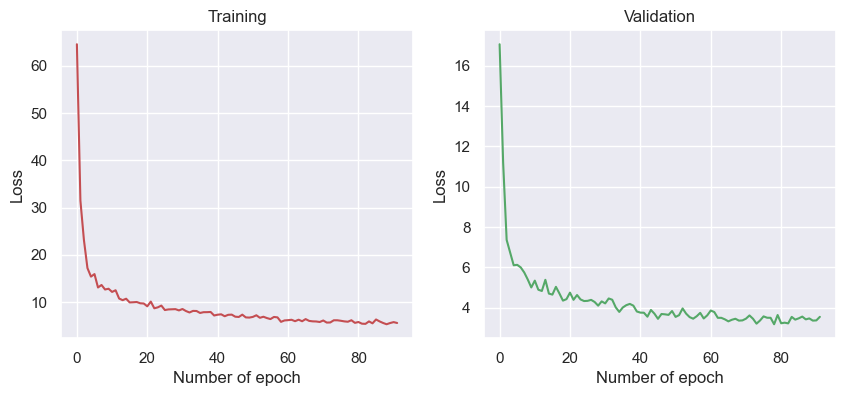

In [67]:
sns.set(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

for ax in (ax1, ax2):
    ax.set_xlabel('Number of epoch')
    ax.set_ylabel('Loss')
ax1.set_title('Training')
ax2.set_title('Validation')

ax1.plot(range(count_of_epochs+1), [i for i in smape_train], c='r')
ax2.plot(range(count_of_epochs+1), [i for i in smape_val], c='g')

In [62]:
train_mae, train_smape, train_mse = compute_metrics(model_best, train_loader, device)
test_mae, test_smape, test_mse = compute_metrics(model_best, test_loader, device)
print(f'MAE, Mean absolute error (train/test): {train_mae:.2f} | {test_mae:.2f}')
print(f'SMAPE, Mean absolute percent error (train/test): {train_smape:.2f}% | {test_smape:.2f}%')
print(f'MSE, Mean squared error (train/test): {train_mse:.2f} | {test_mse:.2f}')

MAE, Mean absolute error (train/test): 0.10 | 0.26
SMAPE, Mean absolute percent error (train/test): 2.86% | 6.51%
MSE, Mean squared error (train/test): 0.15 | 0.42


In [63]:
eval_data = data_features.values[:50]
eval_target = data_labels.values[:50]
eval_data = sc.transform(eval_data)
eval_dataset = MyDataset(eval_data, eval_target)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
eval_mae, eval_smape, eval_mse = compute_metrics(model_best, eval_loader, device)
print(f'MAE, Mean absolute error (eval): {eval_mae:.2f}')
print(f'SMAPE, Mean absolute percent error (eval): {eval_smape:.2f}%')
print(f'MSE, Mean squared error (eval): {eval_mse:.2f}')

MAE, Mean absolute error (eval): 0.48
SMAPE, Mean absolute percent error (eval): 12.32%
MSE, Mean squared error (eval): 0.64


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c8d097c4-ff37-4c1f-a32d-1c9b922540a4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>